In [1]:
!pip install statsmodels

## **<font color='#8d5383'>import library</font>**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import PoissonRegressor
import statsmodels.api as sm

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
# تابع برای تولید داده‌های شبیه‌سازی شده ZIP
def generate_zip_data(n_samples=2000, n_features=3):
    """
    داده‌های شمارشی با تورم در صفر و روابط غیرخطی تولید می‌کند.
    """
    np.random.seed(42)
    X = np.random.rand(n_samples, n_features) * 2 - 1

    log_lambda = 0.5 * X[:, 0] + 0.8 * np.sin(np.pi * X[:, 1]) - 0.3 * X[:, 2]**2
    lambda_ = np.exp(log_lambda)
    logit_pi = -0.6 + 1.2 * X[:, 0] - 0.9 * np.cos(np.pi * X[:, 1])
    pi_ = 1 / (1 + np.exp(-logit_pi))

    is_structural_zero = np.random.binomial(1, pi_, size=n_samples)
    poisson_counts = np.random.poisson(lambda_)
    y = (1 - is_structural_zero) * poisson_counts

    return X, y

In [4]:
X, y = generate_zip_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1) # تغییر شکل برای سازگاری
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# ساخت DataLoader برای مدیریت بچ‌ها
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

print(f"درصد صفرها در داده‌ها: {np.mean(y == 0) * 100:.2f}%")

درصد صفرها در داده‌ها: 65.95%


## **<font color='#8d5383'>creare Models</font>**

In [5]:
class PoissonNN(nn.Module):
    def __init__(self, input_size):
        super(PoissonNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return torch.exp(self.network(x))

In [6]:
class ZIPNN(nn.Module):
    def __init__(self, input_size):
        super(ZIPNN, self).__init__()
        self.shared_layers = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.lambda_head = nn.Linear(16, 1)
        self.pi_head = nn.Linear(16, 1)

    def forward(self, x):
        shared_output = self.shared_layers(x)

        # پیش‌بینی لاندا (باید مثبت باشد)
        lambda_pred = torch.exp(self.lambda_head(shared_output))

        # پیش‌بینی پی (باید بین ۰ و ۱ باشد)
        pi_pred = torch.sigmoid(self.pi_head(shared_output))

        # ترکیب دو خروجی
        return torch.cat((lambda_pred, pi_pred), dim=1)

In [7]:
def zero_inflated_poisson_loss(y_pred, y_true):
    lambda_pred = y_pred[:, 0]
    pi_pred = y_pred[:, 1]

    #  برای داده‌های صفر و غیرصفر
    is_zero = (y_true == 0).float()
    is_nonzero = (y_true > 0).float()

    # لگاریتم درستنمایی برای y = 0
    log_likelihood_zeros = torch.log(pi_pred + (1 - pi_pred) * torch.exp(-lambda_pred) + 1e-10)

    # لگاریتم درستنمایی برای y > 0
    # log(y!) با استفاده از lgamma(y+1) محاسبه می‌شود
    log_likelihood_nonzeros = (
        torch.log(1 - pi_pred + 1e-10)
        - lambda_pred
        + y_true * torch.log(lambda_pred + 1e-10)
        - torch.lgamma(y_true + 1.0)
    )

    # ترکیب دو بخش
    log_likelihood = is_zero * log_likelihood_zeros + is_nonzero * log_likelihood_nonzeros.squeeze()

    # بازگرداندن منفی میانگین لگاریتم درستنمایی
    return -torch.mean(log_likelihood)

In [8]:
def train_model(model, loader, loss_fn, optimizer, num_epochs=100):
    print(f"شروع آموزش مدل: {model.__class__.__name__}")
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in loader:
            # ۱. پیش‌گویی
            y_pred = model(X_batch)

            # ۲. محاسبه زیان
            loss = loss_fn(y_pred, y_batch.squeeze())

            # ۳. پس‌انتشار (Backpropagation)
            optimizer.zero_grad() # صفر کردن گرادیان‌ها
            loss.backward() # محاسبه گرادیان‌ها
            optimizer.step() # به‌روزرسانی وزن‌ها

            total_loss += loss.item()

        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(loader):.4f}')
    print("آموزش تمام شد.\n")

In [9]:
poisson_nn_model = PoissonNN(input_size=X_train.shape[1])

# log_input=False چون ما خودمان در مدل exp را اعمال کرده‌ایم
poisson_loss_fn = nn.PoissonNLLLoss(log_input=False)
poisson_optimizer = torch.optim.Adam(poisson_nn_model.parameters(), lr=0.005)
train_model(poisson_nn_model, train_loader, poisson_loss_fn, poisson_optimizer)

# --- آموزش مدل ZIP NN ---
zip_nn_model = ZIPNN(input_size=X_train.shape[1])
zip_optimizer = torch.optim.Adam(zip_nn_model.parameters(), lr=0.005)
train_model(zip_nn_model, train_loader, zero_inflated_poisson_loss, zip_optimizer)

شروع آموزش مدل: PoissonNN
Epoch [20/100], Loss: 0.8972
Epoch [40/100], Loss: 0.8969
Epoch [60/100], Loss: 0.8964
Epoch [80/100], Loss: 0.8969
Epoch [100/100], Loss: 0.8964
آموزش تمام شد.

شروع آموزش مدل: ZIPNN
Epoch [20/100], Loss: 0.9396
Epoch [40/100], Loss: 0.9308
Epoch [60/100], Loss: 0.9257
Epoch [80/100], Loss: 0.9205
Epoch [100/100], Loss: 0.9151
آموزش تمام شد.



In [10]:
poisson_reg_model = PoissonRegressor(alpha=0)
poisson_reg_model.fit(X_train, y_train)

# مدل ZIP از Statsmodels
X_train_sm = sm.add_constant(X_train)
zip_stats_model = sm.ZeroInflatedPoisson(endog=y_train, exog=X_train_sm).fit(maxiter=100)

Optimization terminated successfully.
         Current function value: 1.000457
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21


In [11]:
# پیش‌گویی مدل‌های آماری
y_pred_poisson_reg = poisson_reg_model.predict(X_test)
X_test_sm = sm.add_constant(X_test)
y_pred_zip_stats = zip_stats_model.predict(X_test_sm)

# پیش‌بینی مدل‌های PyTorch
poisson_nn_model.eval() # تنظیم مدل به حالت ارزیابی
zip_nn_model.eval()
with torch.no_grad(): # غیرفعال کردن محاسبه گرادیان
    y_pred_poisson_nn_t = poisson_nn_model(X_test_t)
    zip_nn_preds_t = zip_nn_model(X_test_t)

# تبدیل تنسورهای خروجی به آرایه‌های NumPy
y_pred_poisson_nn = y_pred_poisson_nn_t.numpy().flatten()
zip_nn_preds = zip_nn_preds_t.numpy()
# مقدار مورد انتظار برای ZIP برابر است با (1-π) * λ
y_pred_zip_nn = (1 - zip_nn_preds[:, 1]) * zip_nn_preds[:, 0]

## **<font color='#8d5383'>Models evaluation</font>**

In [12]:
def calculate_metrics(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return {"Model": model_name, "MAE": mae, "RMSE": rmse}

Model Error Comparison (Lower is better):
                              Model       MAE      RMSE
0         Simple Poisson Regression  0.822128  1.095390
1  Poisson Neural Network (PyTorch)  0.841557  1.110495
2             Statistical ZIP Model  0.837804  1.107898
3      ZIP Neural Network (PyTorch)  0.757330  1.059153


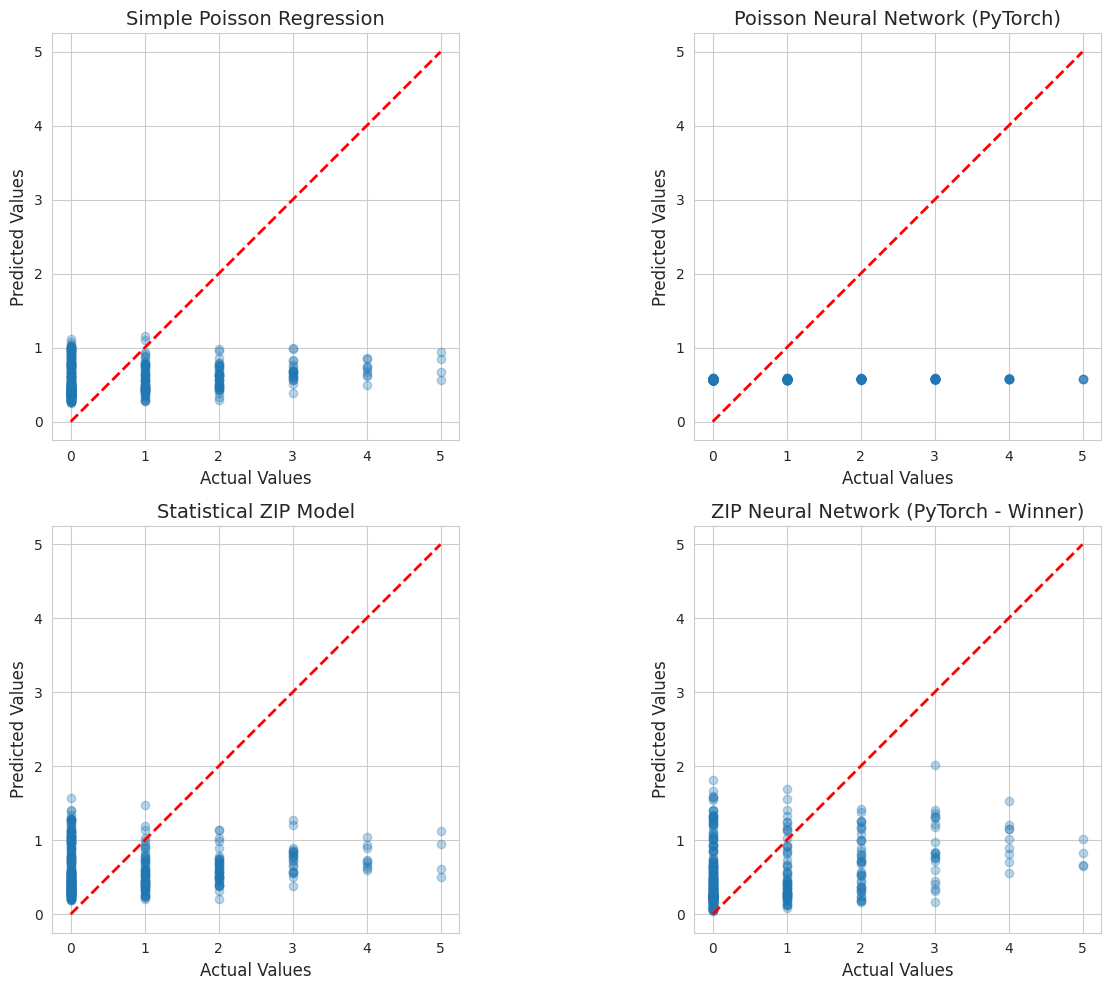

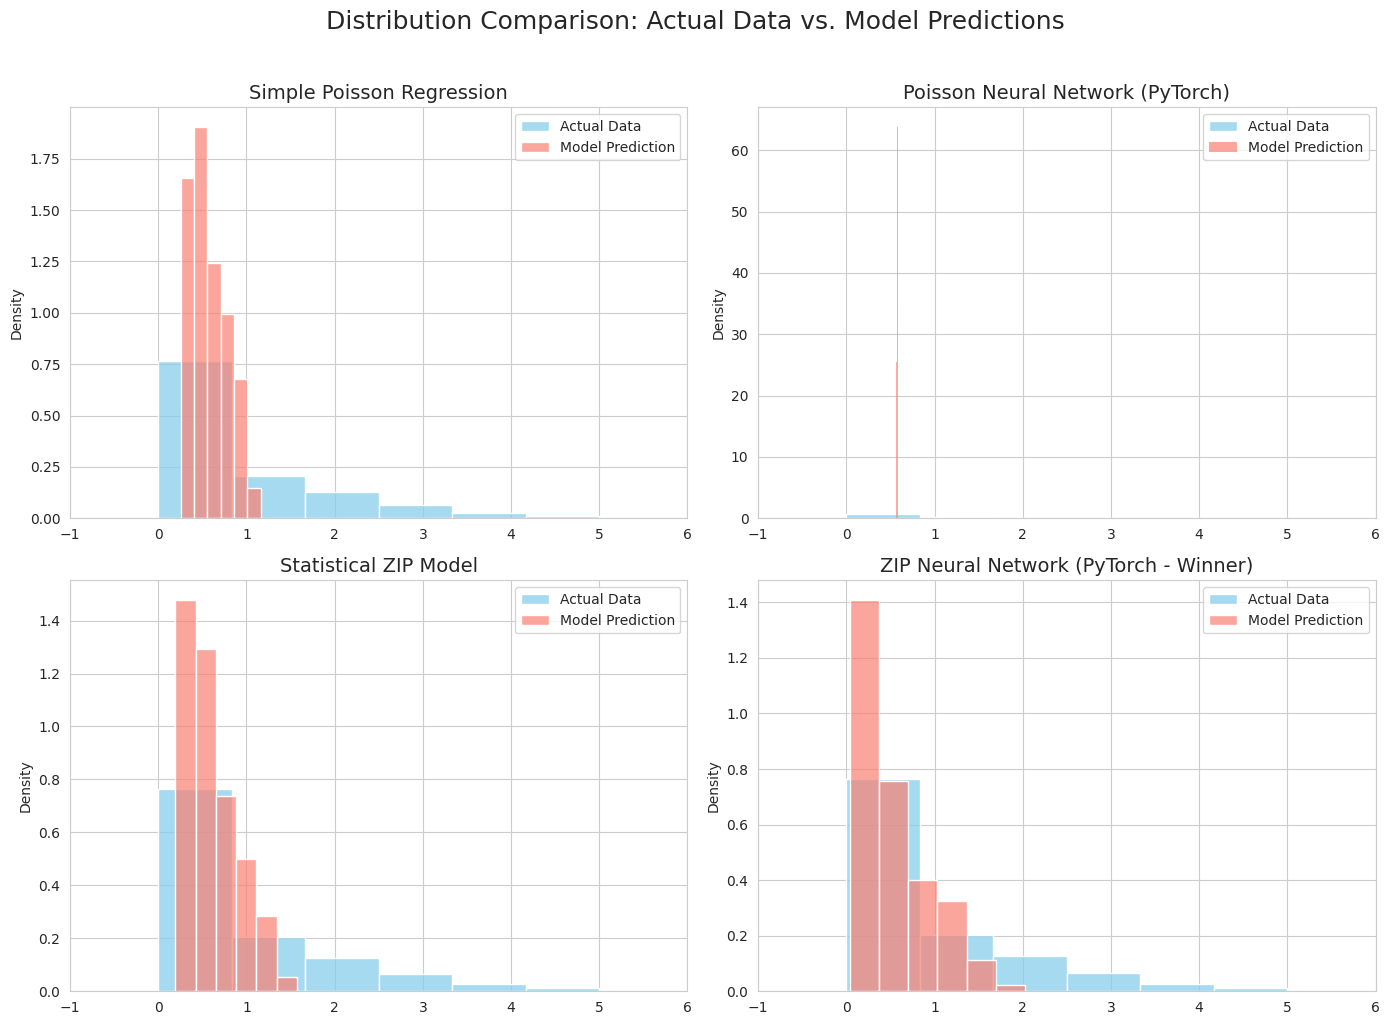

In [13]:
results = []
results.append(calculate_metrics(y_test, y_pred_poisson_reg, "Simple Poisson Regression"))
results.append(calculate_metrics(y_test, y_pred_poisson_nn, "Poisson Neural Network (PyTorch)"))
results.append(calculate_metrics(y_test, y_pred_zip_stats, "Statistical ZIP Model"))
results.append(calculate_metrics(y_test, y_pred_zip_nn, "ZIP Neural Network (PyTorch)"))

results_df = pd.DataFrame(results)
print("Model Error Comparison (Lower is better):")
print(results_df)

# Scatter Plot: Actual vs. Predicted Values
plt.figure(figsize=(14, 10))
models_preds = {
    "Simple Poisson Regression": y_pred_poisson_reg,
    "Poisson Neural Network (PyTorch)": y_pred_poisson_nn,
    "Statistical ZIP Model": y_pred_zip_stats,
    "ZIP Neural Network (PyTorch - Winner)": y_pred_zip_nn
}

for i, (name, preds) in enumerate(models_preds.items()):
    plt.subplot(2, 2, i + 1)
    plt.scatter(y_test, preds, alpha=0.3)
    plt.plot([0, y_test.max()], [0, y_test.max()], '--', color='red', lw=2)
    plt.title(name, fontsize=14)
    plt.xlabel("Actual Values", fontsize=12)
    plt.ylabel("Predicted Values", fontsize=12)
    plt.axis('equal')
    plt.axis('square')

plt.tight_layout()
plt.show()

# Distribution Plot
plt.figure(figsize=(14, 10))
for i, (name, preds) in enumerate(models_preds.items()):
    plt.subplot(2, 2, i + 1)
    sns.histplot(y_test, bins=max(y_test)+1, color='skyblue', label='Actual Data', stat='density')
    sns.histplot(preds, bins=max(y_test)+1, color='salmon', label='Model Prediction', stat='density', alpha=0.7)
    plt.title(name, fontsize=14)
    plt.legend()
    plt.xlim(-1, max(y_test)+1)

plt.suptitle("Distribution Comparison: Actual Data vs. Model Predictions", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

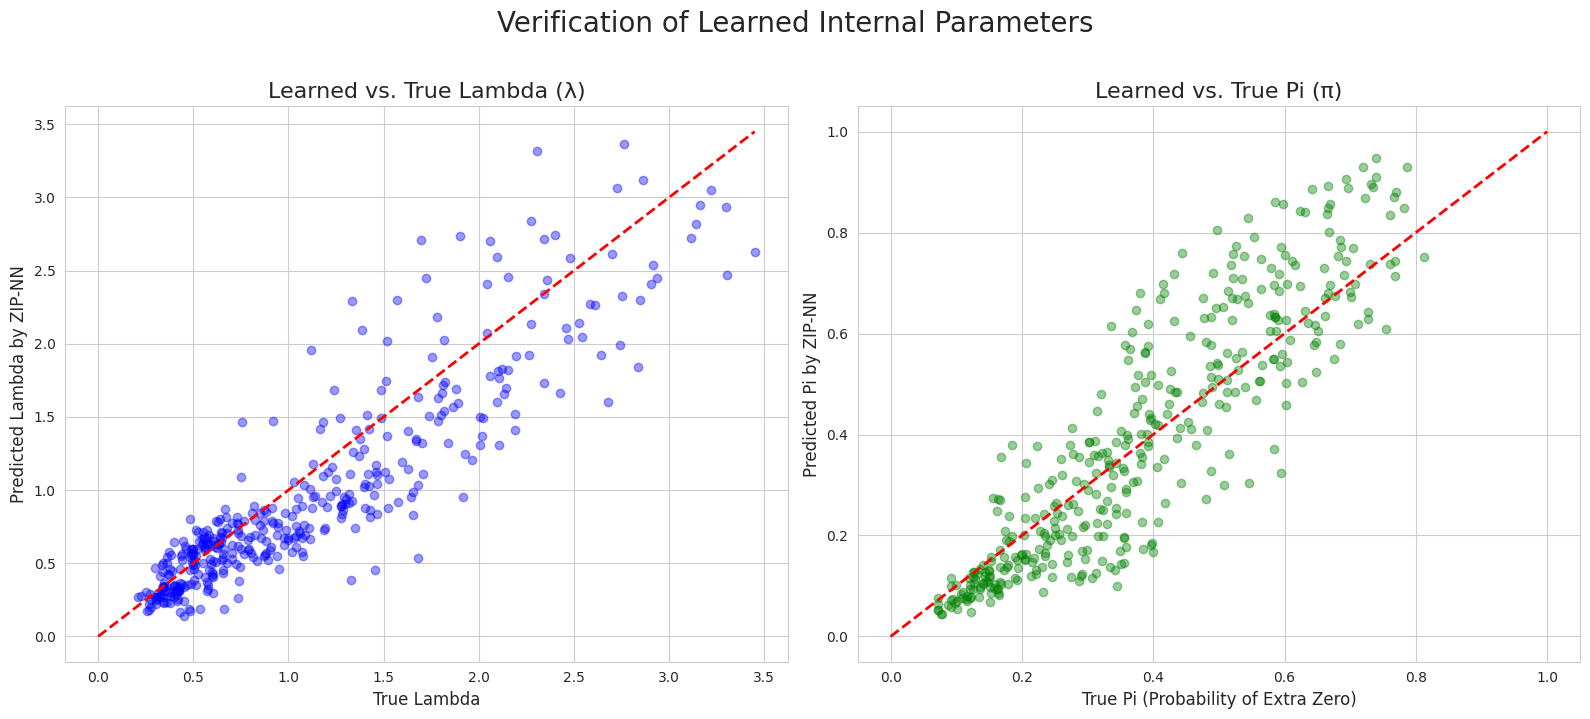

In [14]:
# مقادیر واقعی لاندا و پی برای داده‌های آزمون
# (این مقادیر هنگام تقسیم داده‌ها باید جدا می‌شدند، اینجا برای سادگی دوباره می‌سازیم)
X_test_df = pd.DataFrame(X_test, columns=['f1', 'f2', 'f3'])
log_lambda_true_test = 0.5 * X_test_df['f1'] + 0.8 * np.sin(np.pi * X_test_df['f2']) - 0.3 * X_test_df['f3']**2
lambda_true_test = np.exp(log_lambda_true_test)
logit_pi_true_test = -0.6 + 1.2 * X_test_df['f1'] - 0.9 * np.cos(np.pi * X_test_df['f2'])
pi_true_test = 1 / (1 + np.exp(-logit_pi_true_test))

# پیش‌گویی‌های مدل ZIP-NN برای لاندا و پی
lambda_pred_zip_nn = zip_nn_preds[:, 0]
pi_pred_zip_nn = zip_nn_preds[:, 1]

# رسم نمودارها
plt.figure(figsize=(16, 7))

# نمودار برای لاندا
plt.subplot(1, 2, 1)
plt.scatter(lambda_true_test, lambda_pred_zip_nn, alpha=0.4, c='blue')
plt.plot([0, lambda_true_test.max()], [0, lambda_true_test.max()], '--', color='red', lw=2)
plt.title('Learned vs. True Lambda (λ)', fontsize=16)
plt.xlabel('True Lambda', fontsize=12)
plt.ylabel('Predicted Lambda by ZIP-NN', fontsize=12)
plt.grid(True)

# نمودار برای پی
plt.subplot(1, 2, 2)
plt.scatter(pi_true_test, pi_pred_zip_nn, alpha=0.4, c='green')
plt.plot([0, 1], [0, 1], '--', color='red', lw=2)
plt.title('Learned vs. True Pi (π)', fontsize=16)
plt.xlabel('True Pi (Probability of Extra Zero)', fontsize=12)
plt.ylabel('Predicted Pi by ZIP-NN', fontsize=12)
plt.grid(True)

plt.suptitle('Verification of Learned Internal Parameters', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

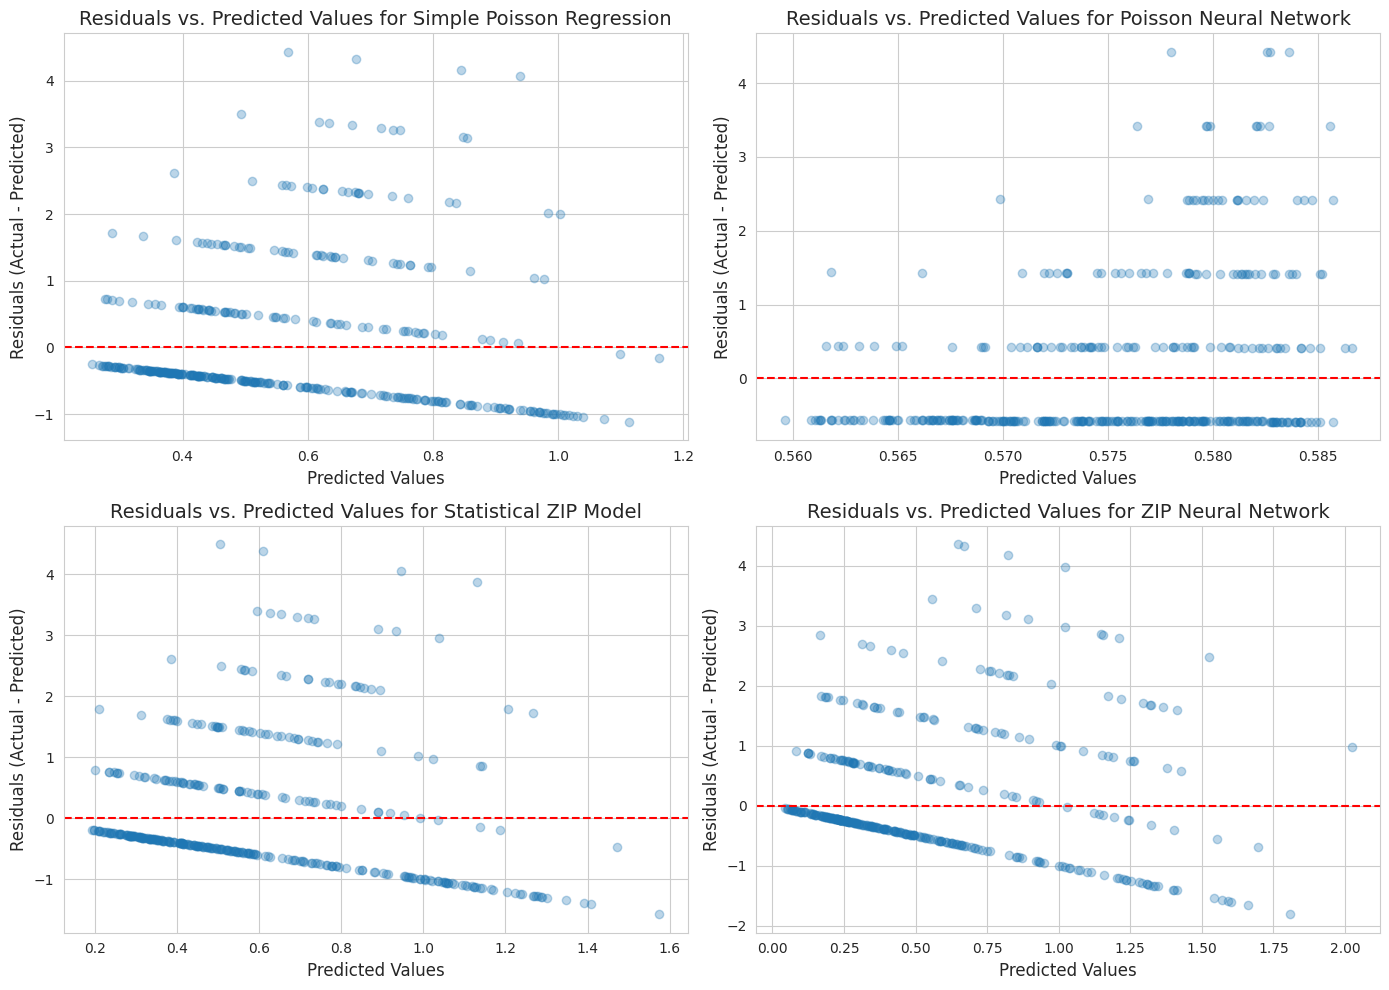

In [15]:
# محاسبه باقی‌مانده‌ها برای هر مدل
residuals = {
    "Simple Poisson Regression": y_test - y_pred_poisson_reg,
    "Poisson Neural Network": y_test - y_pred_poisson_nn,
    "Statistical ZIP Model": y_test - y_pred_zip_stats,
    "ZIP Neural Network": y_test - y_pred_zip_nn
}

# رسم نمودار باقی‌مانده‌ها در مقابل مقادیر پیش‌گویی شده
plt.figure(figsize=(14, 10))

for i, (name, res) in enumerate(residuals.items()):
    plt.subplot(2, 2, i + 1)
    # از y_pred مربوط به هر مدل استفاده می‌کنیم
    preds = models_preds[list(models_preds.keys())[i]]
    plt.scatter(preds, res, alpha=0.3)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f'Residuals vs. Predicted Values for {name}', fontsize=14)
    plt.xlabel('Predicted Values', fontsize=12)
    plt.ylabel('Residuals (Actual - Predicted)', fontsize=12)
    plt.grid(True)

plt.tight_layout()
plt.show()

/tmp/ipython-input-3969909415.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model_Short_Name', y='MAE', data=results_df, palette='viridis')
/tmp/ipython-input-3969909415.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model_Short_Name', y='RMSE', data=results_df, palette='plasma')


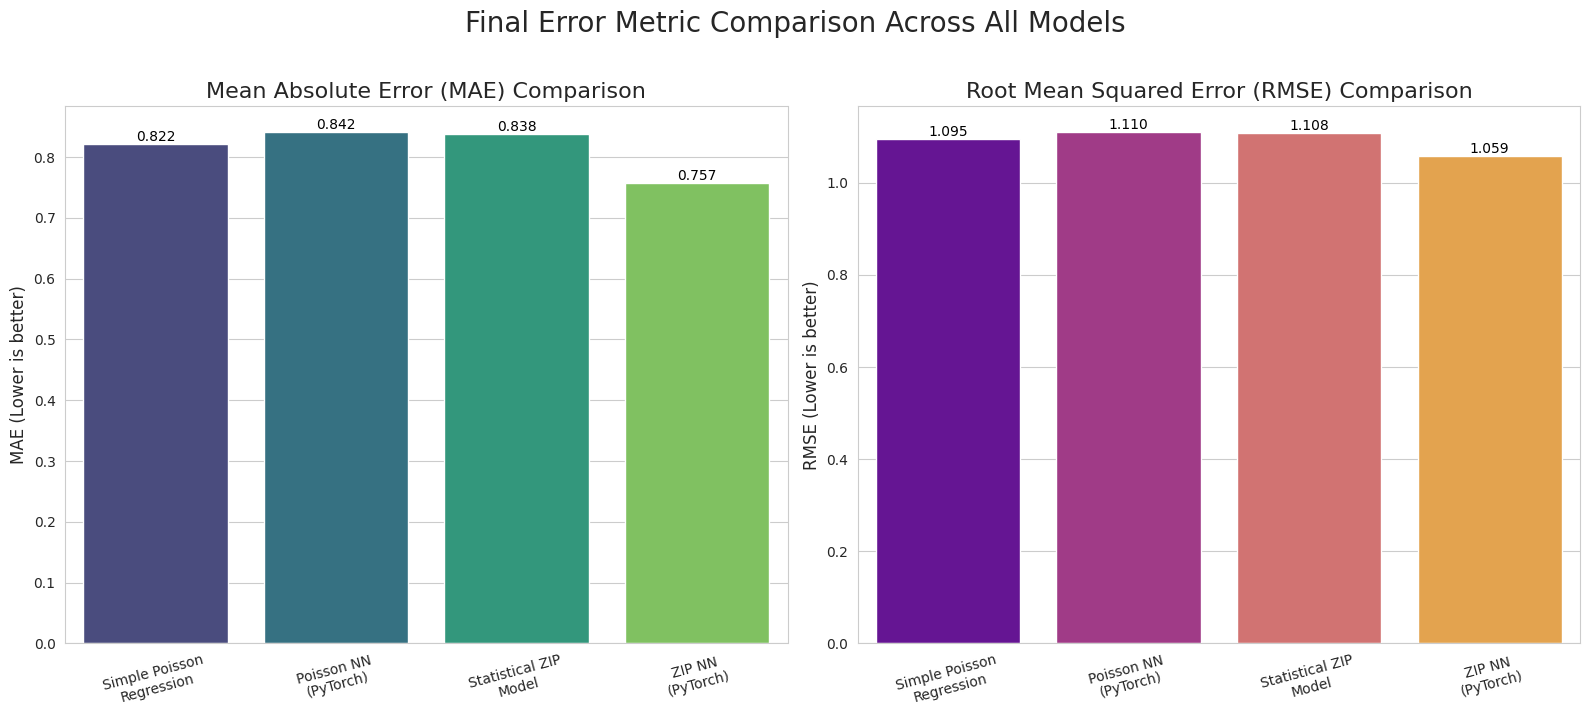

In [16]:
model_names_eng = [
    "Simple Poisson\nRegression",
    "Poisson NN\n(PyTorch)",
    "Statistical ZIP\nModel",
    "ZIP NN\n(PyTorch)"
]
results_df['Model_Short_Name'] = model_names_eng

plt.figure(figsize=(16, 7))

# نمودار برای MAE
plt.subplot(1, 2, 1)
sns.barplot(x='Model_Short_Name', y='MAE', data=results_df, palette='viridis')
plt.title('Mean Absolute Error (MAE) Comparison', fontsize=16)
plt.ylabel('MAE (Lower is better)', fontsize=12)
plt.xlabel('')
plt.xticks(rotation=15) # کمی چرخش برای خوانایی بهتر
for index, row in results_df.iterrows():
    plt.text(index, row['MAE'], f"{row['MAE']:.3f}", color='black', ha="center", va='bottom')


# نمودار برای RMSE
plt.subplot(1, 2, 2)
sns.barplot(x='Model_Short_Name', y='RMSE', data=results_df, palette='plasma')
plt.title('Root Mean Squared Error (RMSE) Comparison', fontsize=16)
plt.ylabel('RMSE (Lower is better)', fontsize=12)
plt.xlabel('')
plt.xticks(rotation=15)
for index, row in results_df.iterrows():
    plt.text(index, row['RMSE'], f"{row['RMSE']:.3f}", color='black', ha="center", va='bottom')

plt.suptitle('Final Error Metric Comparison Across All Models', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

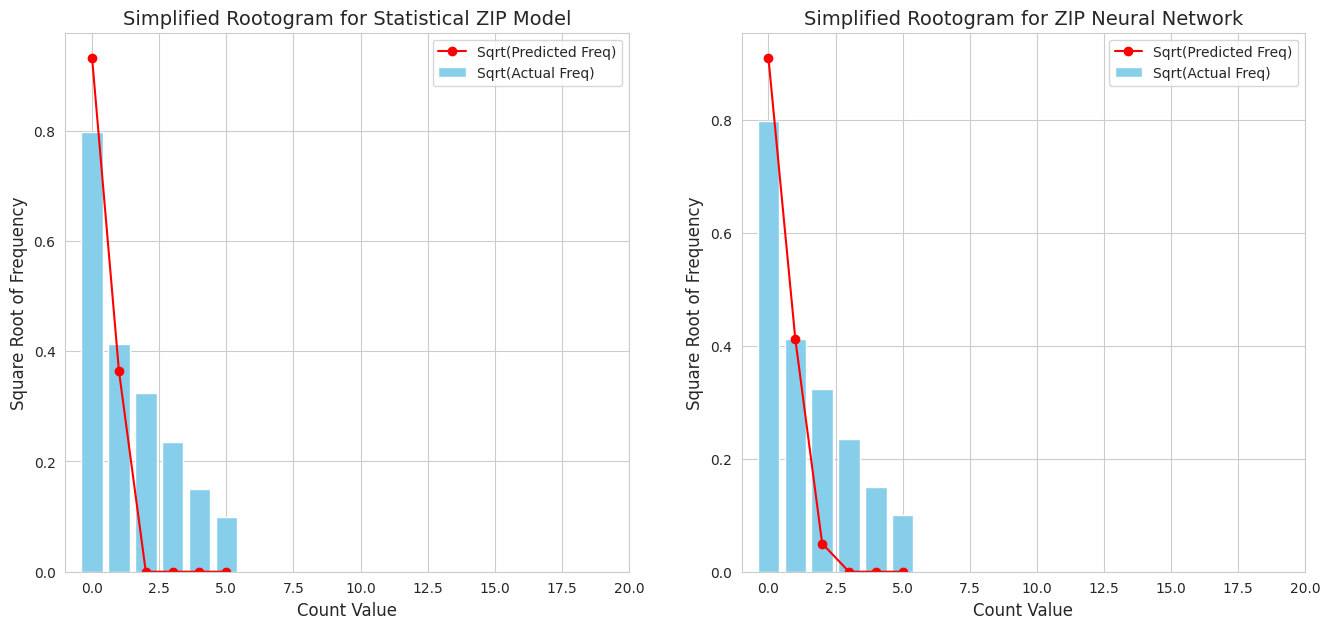

In [17]:
def plot_rootogram(y_true, y_pred, model_name):
    """
    تابعی ساده برای رسم روتوگرام به صورت دستی.
    """
    freq_true = np.bincount(y_true.astype(int))
    max_val = len(freq_true)

    # برای مدل، باید توزیع کامل را برای هر مشاهده پیش‌گویی کنیم و سپس میانگین بگیریم
    # این کار پیچیده است. به جای آن، از توزیع پیش‌گویی‌های نهایی استفاده می‌کنیم که تقریب خوبی است.
    # یک روش دقیق‌تر نیاز به پیاده‌سازی کامل تابع توزیع احتمال هر مدل دارد.
    # در اینجا از هیستوگرام مقادیر پیش‌گویی شده استفاده می‌کنیم.

    # برای سادگی بصری، فراوانی‌ها را مقایسه می‌کنیم.
    freq_pred, _ = np.histogram(y_pred, bins=np.arange(max_val + 1))

    # نرمال‌سازی فراوانی‌ها
    freq_true_norm = freq_true / len(y_true)
    freq_pred_norm = freq_pred / len(y_pred)

    sqrt_true = np.sqrt(freq_true_norm)
    sqrt_pred = np.sqrt(freq_pred_norm)

    x = np.arange(max_val)

    plt.bar(x, sqrt_true, color='skyblue', label='Sqrt(Actual Freq)')
    plt.plot(x, sqrt_pred, 'o-', color='red', label='Sqrt(Predicted Freq)')
    plt.title(f'Simplified Rootogram for {model_name}', fontsize=14)
    plt.xlabel('Count Value', fontsize=12)
    plt.ylabel('Square Root of Frequency', fontsize=12)
    plt.legend()
    plt.xlim(-1, 20) # محدود کردن محور x برای نمایش بهتر

plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)
plot_rootogram(y_test, y_pred_zip_stats, 'Statistical ZIP Model')

plt.subplot(1, 2, 2)
plot_rootogram(y_test, y_pred_zip_nn, 'ZIP Neural Network')

plt.show()